In [49]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, os
from collections import Counter
import warnings
import dateutil

In [13]:
# Loading the file
file_path = "Amazon_Reviews.csv"
try:
    df = pd.read_csv(file_path, engine='python', sep=None, on_bad_lines='skip', encoding='utf-8')
except Exception as e:
    print("UTF-8 read failed, trying latin1...", e)
    df = pd.read_csv(file_path, engine='python', sep=None, on_bad_lines='skip', encoding='latin1')

In [16]:
# Displaying number of rows and columns
df.shape

(21214, 9)

In [14]:
# Displaying first 5 rows
df.head(5)

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Eugene ath,/users/66e8185ff1598352d6b3701a,US,1 review,2024-09-16T13:44:26.000Z,Rated 1 out of 5 stars,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","September 16, 2024"
1,Daniel ohalloran,/users/5d75e460200c1f6a6373648c,GB,9 reviews,2024-09-16T18:26:46.000Z,Rated 1 out of 5 stars,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,"September 16, 2024"
2,p fisher,/users/546cfcf1000064000197b88f,GB,90 reviews,2024-09-16T21:47:39.000Z,Rated 1 out of 5 stars,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,"September 16, 2024"
3,Greg Dunn,/users/62c35cdbacc0ea0012ccaffa,AU,5 reviews,2024-09-17T07:15:49.000Z,Rated 1 out of 5 stars,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,"September 17, 2024"
4,Sheila Hannah,/users/5ddbe429478d88251550610e,GB,8 reviews,2024-09-16T18:37:17.000Z,Rated 1 out of 5 stars,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,"September 16, 2024"


In [20]:
# Displaying list of columns
df.columns.tolist()

['Reviewer Name',
 'Profile Link',
 'Country',
 'Review Count',
 'Review Date',
 'Rating',
 'Review Title',
 'Review Text',
 'Date of Experience']

In [24]:
# Displaying information about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21214 entries, 0 to 21213
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Reviewer Name       21214 non-null  object
 1   Profile Link        21163 non-null  object
 2   Country             21054 non-null  object
 3   Review Count        21055 non-null  object
 4   Review Date         21055 non-null  object
 5   Rating              21055 non-null  object
 6   Review Title        21055 non-null  object
 7   Review Text         21055 non-null  object
 8   Date of Experience  20947 non-null  object
dtypes: object(9)
memory usage: 1.5+ MB


In [25]:
# Missing values per column
df.isnull().sum().sort_values(ascending=False)

,0
Date of Experience,267
Country,160
Review Title,159
Review Date,159
Review Count,159
Review Text,159
Rating,159
Profile Link,51
Reviewer Name,0


In [26]:

# Show sample of problematic rows (very long etc.)
df.sample(3, random_state=42)

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
563,Richard Bernhardt,/users/66afa8935db8515466f85d36,US,1 review,2024-08-04T18:13:23.000Z,Rated 2 out of 5 stars,Unbelievable how CS only wants to dictate results,"I will keep it short and say, that when it doe...","August 04, 2024"
1891,Paul Mylod,/users/5e9f19632216ef2ca35447a3,GB,7 reviews,2024-04-07T20:33:51.000Z,Rated 2 out of 5 stars,Delivered Wrong Address,Another delivery that said it was posted throu...,"April 07, 2024"
2518,Lori C,/users/6584a2cab6c3c00011689844,US,2 reviews,2024-01-31T18:16:29.000Z,Rated 1 out of 5 stars,GIFT CARD SCAM,Amazon is also scamming me out of a $100 gift ...,"January 08, 2024"


In [54]:
def extract_first_int(x):
    try:
        s = str(x)
        m = re.search(r'(\d+)', s.replace(',', ''))
        return int(m.group(1)) if m else np.nan
    except:
        return np.nan

In [55]:

def parse_date(x):
    try:
        return pd.to_datetime(x, errors='coerce')
    except:
        return pd.NaT


In [62]:
# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Rating
if 'Rating' in df.columns:
    df['rating_num'] = df['Rating'].apply(extract_first_int).astype('Int64')
else:
    print("No 'Rating' column found; columns:", df.columns.tolist())

# Review count
if 'Review Count' in df.columns:
    df['reviewer_review_count'] = df['Review Count'].apply(extract_first_int).fillna(0).astype(int)
else:
    df['reviewer_review_count'] = 0

# Parse and clean date columns
for col in ['Review Date', 'Date of Experience']:
    if col in df.columns:
        df[col + '_dt'] = pd.to_datetime(df[col], errors='coerce')
        print(f"Parsed {col}: nulls =", df[col + '_dt'].isnull().sum())
    else:
        print(f"{col} not present")

# Drop rows with missing or invalid parsed dates
date_cols = [col + '_dt' for col in ['Review Date', 'Date of Experience'] if col + '_dt' in df.columns]
if date_cols:
    before = df.shape[0]
    df = df.dropna(subset=date_cols).reset_index(drop=True)
    after = df.shape[0]
    print(f"Dropped {before - after} rows with missing or invalid dates across {date_cols}")
else:
    print("No date columns found to drop missing values for.")

# Clean string columns
if 'Reviewer Name' in df.columns:
    df['Reviewer Name'] = df['Reviewer Name'].astype(str).str.strip().replace({'nan':np.nan})
if 'Country' in df.columns:
    df['Country'] = df['Country'].astype(str).str.strip().replace({'nan': np.nan, '': np.nan})
    before = df.shape[0]
    df = df.dropna(subset=['Country']).reset_index(drop=True)
    after = df.shape[0]
    print(f"Dropped {before - after} rows with missing or invalid 'Country' values.")
else:
    print("Column 'Country' not present.")

# Remove duplicates
if 'Review Text' in df.columns:
    before = df.shape[0]
    df = df.drop_duplicates(subset=['Reviewer Name','Review Text'])
    after = df.shape[0]
    print("Dropped exact duplicates:", before-after)
else:
    raise ValueError("Column 'Review Text' not found")

# Drop missing review text
df = df[~df['Review Text'].isnull()].reset_index(drop=True)
print("After dropping missing review text:", df.shape)

Parsed Review Date: nulls = 0
Parsed Date of Experience: nulls = 0
Dropped 0 rows with missing or invalid dates across ['Review Date_dt', 'Date of Experience_dt']
Dropped 1 rows with missing or invalid 'Country' values.
Dropped exact duplicates: 0
After dropping missing review text: (20937, 13)


In [63]:
df.isnull().sum().sort_values(ascending=False)

,0
Reviewer Name,0
Profile Link,0
Country,0
Review Count,0
Review Date,0
Rating,0
Review Title,0
Review Text,0
Date of Experience,0
rating_num,0


**Text Preprocessing**

In [65]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [67]:
STOPWORDS = set(stopwords.words('english'))
LEMMA = WordNetLemmatizer()

CONTRACTIONS = {
    "can't":"cannot", "won't":"will not", "n't":" not", "'re":" are",
    "'s":" is", "'d":" would", "'ll":" will", "'ve":" have", "'m":" am"
}


In [68]:
def expand_contractions(text):
    for k, v in CONTRACTIONS.items():
        text = text.replace(k, v)
    return text

def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', text)

def remove_html(text):
    return re.sub(r'<.*?>', ' ', text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]', ' ', text)

PUNCT_RE = re.compile(r'[%s]' % re.escape(string.punctuation))
def normalize_punct(text):
    return PUNCT_RE.sub(' ', text)

def clean_text_pipeline(text, do_lemmatize=True, remove_stopwords=True):
    if not isinstance(text, str):
        return ''
    text = text.strip().lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = expand_contractions(text)
    text = normalize_punct(text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    if do_lemmatize:
        tokens = [LEMMA.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [69]:
# Apply cleaning
text_cols = [c for c in df.columns if ('review' in c.lower() and ('text' in c.lower() or c.lower().endswith('review'))) or ('title' in c.lower())]
if 'Review Text' not in text_cols:
    text_cols.insert(0, 'Review Text')

for col in text_cols:
    clean_col = col + "_clean"
    df[clean_col] = df[col].astype(str).apply(clean_text_pipeline)
    print(f"Created {clean_col} (sample):")
    display(df[[col, clean_col]].head(2))

Created Review Title_clean (sample):


,Review Title,Review Title_clean
0,A Store That Doesn't Want to Sell Anything,store want sell anything
1,Had multiple orders one turned up and…,multiple order one turned


Created Review Text_clean (sample):


,Review Text,Review Text_clean
0,"I registered on the website, tried to order a ...",registered website tried order laptop entered ...
1,Had multiple orders one turned up and driver h...,multiple order one turned driver phone door nu...


**Feature Engineering**

In [70]:
clean_col = text_cols[0] + "_clean"

df['word_count'] = df[clean_col].apply(lambda x: len(str(x).split()))
df['char_count'] = df[clean_col].apply(lambda x: len(str(x)))
df['unique_words'] = df[clean_col].apply(lambda x: len(set(str(x).split())))
df['avg_word_len'] = df[clean_col].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split())>0 else 0)

try:
    from textblob import TextBlob
    df['polarity'] = df[clean_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['subjectivity'] = df[clean_col].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    print("Computed polarity & subjectivity")
except:
    df['polarity'] = np.nan
    df['subjectivity'] = np.nan

def sentiment_label(r):
    if pd.isna(r): return np.nan
    if r <= 2: return 'negative'
    if r == 3: return 'neutral'
    return 'positive'

df['sentiment'] = df['rating_num'].apply(sentiment_label)
display(df[[clean_col,'word_count','rating_num','sentiment']].head())

Computed polarity & subjectivity


,Review Title_clean,word_count,rating_num,sentiment
0,store want sell anything,4,1,negative
1,multiple order one turned,4,1,negative
2,informed reprobate,2,1,negative
3,advertise one price increase website,5,1,negative
4,could give lower rate would,5,1,negative


**Exploratory Data Analysis**

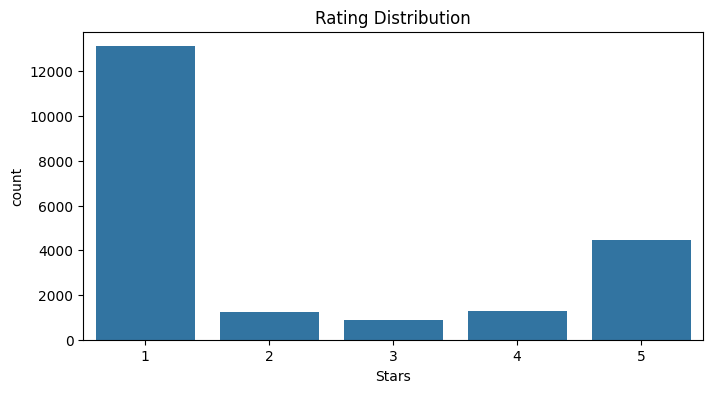

In [71]:
# Rating distribution
if 'rating_num' in df.columns:
    plt.figure(figsize=(8,4))
    order = sorted(df['rating_num'].dropna().unique())
    sns.countplot(x='rating_num', data=df, order=order)
    plt.title('Rating Distribution')
    plt.xlabel('Stars')
    plt.show()

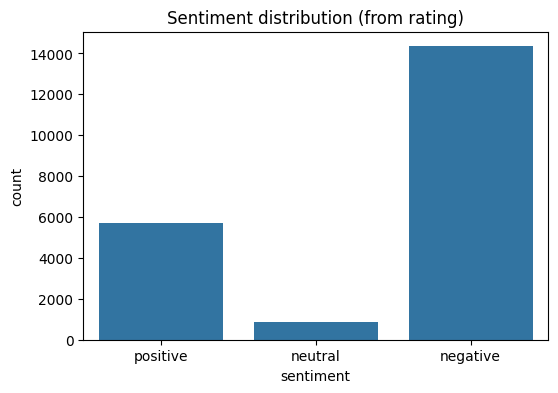

In [72]:
# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=['positive','neutral','negative'])
plt.title('Sentiment distribution (from rating)')
plt.show()


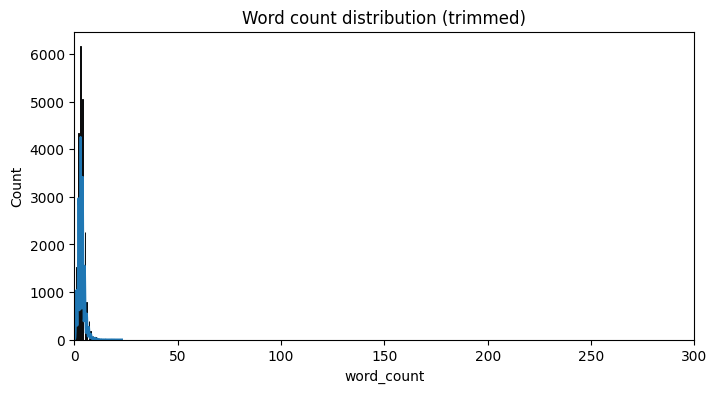

In [73]:
# Word count distribution
plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=60, kde=True)
plt.xlim(0,300)
plt.title('Word count distribution (trimmed)')
plt.show()

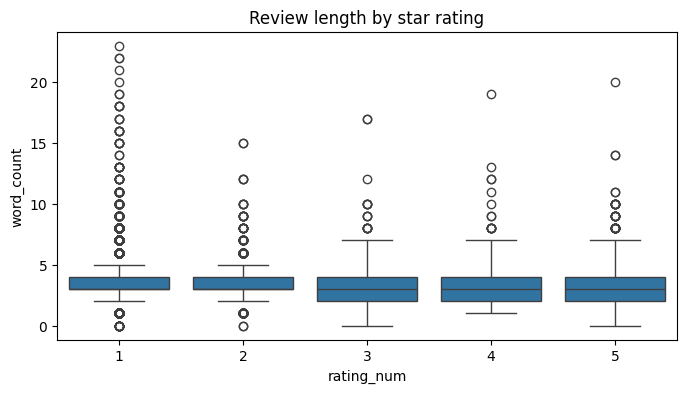

In [74]:
# Boxplot review length vs rating
if 'rating_num' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='rating_num', y='word_count', data=df)
    plt.title('Review length by star rating')
    plt.show()

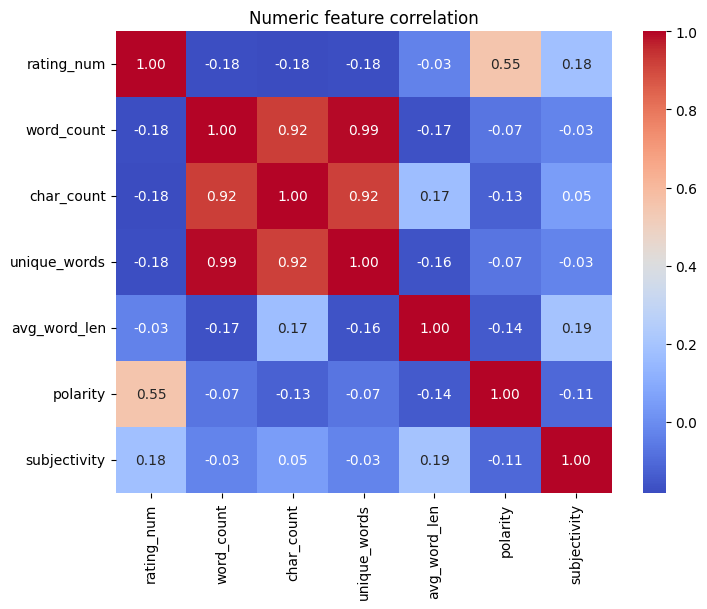

In [75]:

# Correlations
num_cols = [c for c in ['rating_num','word_count','char_count','unique_words','avg_word_len','polarity','subjectivity'] if c in df.columns]
if num_cols:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Numeric feature correlation')
    plt.show()

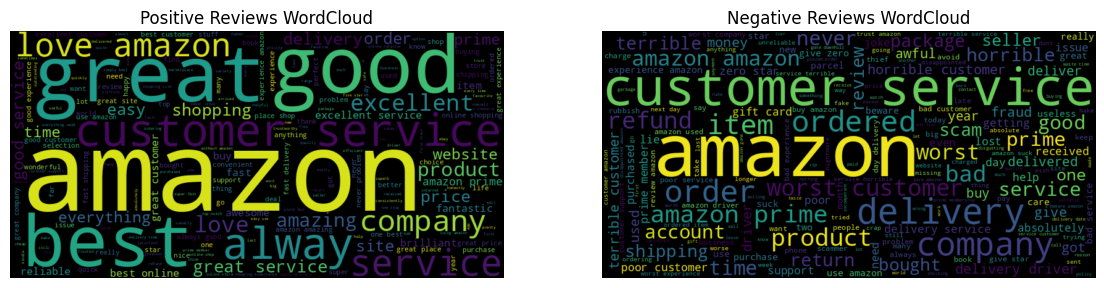

In [76]:
# -------------------------
# 7) Word Clouds
# -------------------------
try:
    from wordcloud import WordCloud
    pos_text = ' '.join(df[df['rating_num']>=4][clean_col].astype(str).tolist())
    neg_text = ' '.join(df[df['rating_num']<=2][clean_col].astype(str).tolist())

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    wc1 = WordCloud(width=800, height=400).generate(pos_text if len(pos_text)>0 else "positive")
    plt.imshow(wc1, interpolation='bilinear'); plt.axis('off'); plt.title('Positive Reviews WordCloud')

    plt.subplot(1,2,2)
    wc2 = WordCloud(width=800, height=400).generate(neg_text if len(neg_text)>0 else "negative")
    plt.imshow(wc2, interpolation='bilinear'); plt.axis('off'); plt.title('Negative Reviews WordCloud')
    plt.show()
except Exception as e:
    print("WordCloud generation failed:", e)
